In [9]:
# This noteboook is just a playground to test and play
# around with some very basic concepts of Neural Networks
# such as:
# -- Weights and Biases
# -- Activation functions
# -- Backpropagation and 
#    (Batch/Mini-batch/Stochastic) Gradient Descent
# -- Overfiting and Regularization (L1, L2)

# Here I implement from scratch simple
# Artifitial Neural Network (ANN) for a classic
# problem of handwriten digits classification (MNIST)
# using just regular Python stack, Numpy and Matplotlib
# for ploting images

# Version 1.0

In [10]:
import sys
import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#importing MNIST dataset
from keras.datasets import mnist

## Loading and visualizing MNIST dataset

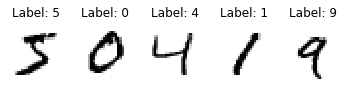

In [11]:
# MNIST dataset contains 70k 28x28 images of hand-wrinten digits
# each one is labeled
# 60k images - learning data, 10k - testing data\n",
(x_train, y_train), (x_test, y_test) = mnist.load_data()
images, labels = (x_train[0:5].reshape(5,28,28)/255,  y_train[0:5])
fig = plt.figure()
for i in range (len(images)):
    plt_sub = fig.add_subplot(1,len(images),i+1)
    plt.imshow(images[i], cmap=mpl.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt_sub.set_title(f"Label: {labels[i]}")
plt.show()

## Preparing training and testing data

In [12]:
#reshaping from (28 x 28) to vector (784)
train_images, train_labels = (x_train[0:60000].reshape(60000,28*28)/255,
                              y_train[0:60000])

# encoding labels with one-hot encoding approach
train_one_hot_labels = np.zeros((len(train_labels), 10))
for i,label in enumerate(train_labels):
    train_one_hot_labels[i][label] = 1
    
train_inputs = train_images
train_targets = train_one_hot_labels
    
# I will aditionaly split training data into traning and validation set\n",
train_inputs = train_images[0:50000]
train_targets = train_one_hot_labels[0:50000]
validation_inputs = train_images[50000:60000]
validation_targets = train_one_hot_labels[50000:60000]
    
# and also I'll use small training dataset\n",
train_inputs_small = train_images[0:10000]
train_targets_small = train_one_hot_labels[0:10000]

# preparing test data (similar to traning data)
# reshaping from (28 x 28) to vector (784)
test_images, test_labels = (x_test[0:10000].reshape(10000,28*28)/255,
                            y_test[0:10000])

test_one_hot_labels = np.zeros((len(test_labels), 10))
for i,label in enumerate(test_labels):
        test_one_hot_labels[i][label] = 1

test_inputs = test_images
test_targets = test_one_hot_labels

## Naive implementation of the Artifitial Neural Network

In [13]:
# This is the very naive implementation of the ANN
# for classification of handwritten digits
# here, I use input and output layers of fixed sizes -
# 784 and 10 correspondingly, and one hidden layer.
# I also use ReLU activation function on hidden layer.
# Weights optimization algorithm - SGD
# L2-norm lossfuncion

# Network settings and utility functions
    
# before each training epoch we'll randomly shuffle (intputs, targets)
def shuffle(*ls):
    l = list(zip(*ls))
    np.random.shuffle(l)
    return map(np.array, zip(*l))

np.random.seed(1)
    
# in this section we setup network topology,
# initial weights and biases,
# as well as determine activation function and learning rate

# Topology of the network
INPUT_LAYER_SIZE = 784 # inputs
hidden_layer_size = 100 # one hidden layer with 100 neurons
OUTPUT_LAYER_SIZE = 10  # outputs

# Initial weights and biases initialized randomly
# using uniform distribution
weights_0_1 = 0.1 * (np.random.random((INPUT_LAYER_SIZE,\
                                        hidden_layer_size)) -0.5)
bias_0_1 = 0.001 * (np.random.random(hidden_layer_size) -0.5)

weights_1_2 = 0.1 * (np.random.random((hidden_layer_size,\
                                        OUTPUT_LAYER_SIZE)) -0.5)
bias_1_2 = 0.001 * (np.random.random(OUTPUT_LAYER_SIZE) -0.5)

# ReLU-activation function for the  hidden layer
relu = lambda x: (x >= 0) * x
# and its derivative
relu_deriv = lambda x: x >= 0

# traning data
inputs = train_inputs
targets = train_targets
# training on < len(inputs) > samples
training_set_size = len(inputs)
    
alpha = 0.0025 # learning rate\n",
epochs = 50 # number of epochs to train"

In [16]:
# Training the network on trainig data-set
print(f"Training ANN on {training_set_size} samples in progress ...")
for it in range(epochs):
    shuffle(inputs, targets)
    loss, correct_cnt = (0.0, 0)
    for i in range(training_set_size):
        # feed forward
        # using single training sample at once
        # while looping over all samples
        layer_0 = inputs[i]
        layer_1 = relu(np.dot(layer_0, weights_0_1) + bias_0_1)
        layer_2 = np.dot(layer_1, weights_1_2) + bias_1_2
        
        # calculating loss-function and number of correcly predicted targets
        predict = np.argmax(layer_2)
        target = np.argmax(targets[i])
        loss += np.sum((targets[i] - layer_2)**2)
        correct_cnt += int(predict == target)
        
        # backpropagation
        layer_2_delta = (targets[i] - layer_2)
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu_deriv(layer_1)
        weights_1_2 += alpha * np.outer(layer_1, layer_2_delta)
        bias_1_2 += alpha * layer_2_delta
        weights_0_1 += alpha * np.outer(layer_0, layer_1_delta)
        bias_0_1 += alpha * layer_1_delta
      
    loss_function = round(loss / training_set_size, 4)
    train_accuracy = round(correct_cnt / training_set_size, 4)
    sys.stdout.write(f"\rEpoch: {it} Loss function value: {loss_function}"+
                     f"\tCorrectly classified {correct_cnt}"+
                     f" of {training_set_size} training images")

print(f"\nTraining finished!\nFinal traning accuracy: {train_accuracy}")

Training ANN on 50000 samples in progress ...
Epoch: 49 Loss function value: 0.265	Correctly classified 43979 of 50000 training imagess
Training finished!
Final traning accuracy: 0.8796


In [19]:
# Testing the network on test dataset
test_set_size = len(test_inputs)
print(f"Testing on {len(test_targets)} test samples")
loss, correct_cnt = (0.0, 0)
      
for i in range(test_set_size):
    # feed forward
    layer_0 = test_inputs[i]
    layer_1 = relu(np.dot(layer_0, weights_0_1) + bias_0_1)
    layer_2 = np.dot(layer_1, weights_1_2) + bias_1_2

    predict = np.argmax(layer_2)
    target = np.argmax(test_targets[i])

    #calculating loss
    loss += np.sum((test_targets[i] - layer_2)**2)
    correct_cnt += int(predict == target)

loss_function = round(loss / test_set_size, 4)
test_accuracy = round(correct_cnt / test_set_size, 4)
sys.stdout.write(f"\rLoss function value: {loss_function}"+
                 f"\tCorrectly classified {correct_cnt}"+
                 f" of {len(test_targets)} images" )
print(f"\nTest accuracy: {test_accuracy}")

Testing on 10000 test samples
Loss function value: 0.2793	Correctly classified 8835 of 10000 images
Test accuracy: 0.8835


## Using Mini-batch Gradient Descent

In [20]:
# ^^^ That was realy slooow
# (not even talking about the bad accuracy at this point)
# lets try to speedup the training process
# by using multiple samples at each step of the training epoch -
# Batch Gradient Descent approach

In [21]:
# Network settings and utility functions

# before each training epoch we'll randomly shuffle (intputs, targets)
def shuffle(*ls):
    l = list(zip(*ls))
    np.random.shuffle(l)
    return map(np.array, zip(*l))

# in this section we setup network topology, initial weights and biases,
# as well as determine activation function and learning rate
np.random.seed(1)

# Topology of the network
INPUT_LAYER_SIZE = 784 # inputs
hidden_layer_size = 100 # one hidden layer with 100 neurons
OUTPUT_LAYER_SIZE = 10  # outputs

# Initial weights and biases initialized randomly using uniform distribution
weights_0_1 = 0.025 * (np.random.random((INPUT_LAYER_SIZE,\
                                         hidden_layer_size))-0.5)
bias_0_1 = 0.001 * (np.random.random(hidden_layer_size)-0.5)

weights_1_2 = 0.025 * (np.random.random((hidden_layer_size,\
                                         OUTPUT_LAYER_SIZE))-0.5)
bias_1_2 = 0.001 * (np.random.random(OUTPUT_LAYER_SIZE)-0.5)

# ReLU-activation function for the  hidden layer
relu = lambda x: (x >= 0) * x
# and its derivative
relu_deriv = lambda x: x >= 0
 
# traning data
inputs = train_inputs
targets = train_targets
training_set_size = len(inputs) # training on < len(inputs) > samples

# learning hyperparameters
alpha = 0.007 # learning rate
epochs = 120 # number of epochs to train

# here we define batch size, to use batch of samples instead
# of single sample for input at each training step
batch_size = 20

In [22]:
# Training the network
print(f"Training ANN on {training_set_size} samples in progress...")
for it in range(epochs):
    inputs,targets = shuffle(inputs, targets)
    loss, correct_cnt = (0.0, 0)
     
    for i in range(training_set_size//batch_size):
        batch_start,batch_end = (i*batch_size, (i+1)*batch_size)
        # feed forward
        # using batch of samples instead of single sample
        layer_0 = inputs[batch_start:batch_end]
        layer_1 = relu(np.dot(layer_0, weights_0_1) + bias_0_1)
        layer_2 = np.dot(layer_1, weights_1_2) + bias_1_2
        
        # calculating loss-function and number of correcly predicted targets
        loss += np.sum((targets[batch_start:batch_end] - layer_2)**2)
        for k in range(batch_size):
            correct_cnt += int(np.argmax(layer_2[k:k+1]) == \
                                np.argmax(targets[(batch_start+k):(batch_start+k+1)]))
         
        # backpropagation
        layer_2_delta = (targets[batch_start:batch_end] - layer_2)/batch_size
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu_deriv(layer_1)
        weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
        bias_1_2 += alpha * np.sum(layer_2_delta, axis = 0)
        weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)
        bias_0_1 += alpha * np.sum(layer_1_delta, axis = 0)
     
    loss_function = round(loss / training_set_size, 4)
    train_accuracy = round(correct_cnt / training_set_size, 4)
    sys.stdout.write(f"\rEpoch: {it} Loss function value: {loss_function}"+
                     f"\tCorrectly classified {correct_cnt} of "+
                     f"{training_set_size} training images")
print(f"\nTraining finished!\nFinal traning accuracy: {train_accuracy}")

Training ANN on 50000 samples in progress...
Epoch: 119 Loss function value: 0.2255	Correctly classified 45552 of 50000 training images
Training finished!
Final traning accuracy: 0.911


In [23]:
# Testing the network on test dataset
test_set_size = len(test_inputs)
print(f"Testing on {len(test_targets)} test samples")
loss, correct_cnt = (0.0, 0)

for i in range(test_set_size):
    # feed forward
    layer_0 = test_inputs[i]
    layer_1 = relu(np.dot(layer_0, weights_0_1) + bias_0_1)
    layer_2 = np.dot(layer_1, weights_1_2) + bias_1_2
    
    predict = np.argmax(layer_2)
    target = np.argmax(test_targets[i])\

    #calculating loss
    loss += np.sum((test_targets[i] - layer_2)**2)
    correct_cnt += int(predict == target)
    
loss_function = round(loss / test_set_size, 4)
test_accuracy = round(correct_cnt / test_set_size, 4)
sys.stdout.write(f"\rLoss function value: {loss_function}"+
                 f"\tCorrectly classified {correct_cnt}"+
                 f" of {len(test_targets)} images" )
print(f"\nTest accuracy: {test_accuracy}")

Testing on 10000 test samples
Loss function value: 0.225	Correctly classified 9093 of 10000 images
Test accuracy: 0.9093


## Using tahn and softmax activation functions

In [25]:
# ^^^ Using Mini-batched Gradient Descent significnatly
# speeds up training process.

# Now let's experiment with activation layers
# to improve accuracy of the model
# Here I aply tahn activation to the hidden layer
# and sofmax activation to the output layer

# I will, also, use the validation set to track
# learning process

# Network settings and utility functions

# using tanh and softmax activation
tanh = lambda x: np.tanh(x)
tanh_deriv = lambda x: 1 - x**2
softmax = lambda x: np.exp(x) / np.sum(np.exp(x),\
                                        axis = 1, keepdims = True)

# before each training epoch we'll randomly shuffle (intputs, targets)
def shuffle(*ls):
    l = list(zip(*ls))
    np.random.shuffle(l)
    return map(np.array, zip(*l))

np.random.seed(1)

# Topology of the network
INPUT_LAYER_SIZE = 784 # inputs
hidden_layer_size = 100 # one hidden layer with 100 neurons
OUTPUT_LAYER_SIZE = 10  # outputs

# Initial weights and biases initialized randomly using uniform distribution
weights_0_1 = 0.05  * (np.random.random((INPUT_LAYER_SIZE,\
                                         hidden_layer_size))-0.5)
bias_0_1 = 0.0 * (np.random.random(hidden_layer_size)-0.5)

weights_1_2 = 0.05  * (np.random.random((hidden_layer_size,\
                                         OUTPUT_LAYER_SIZE))-0.5)
bias_1_2 = 0.0 * (np.random.random(OUTPUT_LAYER_SIZE)-0.5)

# traning data
inputs = train_inputs
targets = train_targets
training_set_size = len(inputs) #training on < len(inputs) > samples

#using validation
validation_set_size = len(validation_inputs)

# learning hyperparameters
alpha = 0.05 # learning rate
epochs = 250 # number of epochs to train

# here we define batch size, to use batch of samples
#instead of single sample for input at each training step
batch_size  = 20

In [27]:
# Training the network
print(f"Training ANN on {training_set_size} samples in progress...")
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []
for it in range(epochs):
    inputs,targets = shuffle(inputs, targets)
    loss, correct_cnt = (0.0, 0)

    for i in range(training_set_size//batch_size):
        batch_start,batch_end = (i*batch_size, (i+1)*batch_size)
        # TRANING
        # feed forward
        # using mini-batch instead of single sample
        layer_0 = inputs[batch_start:batch_end]
        layer_1 = tanh(np.dot(layer_0, weights_0_1) + bias_0_1)
        layer_2 = softmax(np.dot(layer_1, weights_1_2) + bias_1_2)

        # calculating loss-function and number of correcly predicted targets
        loss += np.sum((targets[batch_start:batch_end] - layer_2)**2)
        for k in range(batch_size):
            correct_cnt += int(np.argmax(layer_2[k:k+1]) ==\
                               np.argmax(targets[(batch_start+k):(batch_start+k+1)]))
            
        # backpropagation
        layer_2_delta = (targets[batch_start:batch_end] - layer_2)\
                        /(batch_size * layer_2.shape[0])
        layer_1_delta = layer_2_delta.dot(weights_1_2.T)\
                        *tanh_deriv(layer_1)
        weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
        bias_1_2 += alpha * np.sum(layer_2_delta, axis = 0)
        weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)
        bias_0_1 += alpha * np.sum(layer_1_delta, axis = 0)
        
    loss_function = round(loss / training_set_size, 4)
    train_loss.append(loss_function)
    train_accuracy = round(correct_cnt / training_set_size, 4)
    train_acc.append(train_accuracy)

    # VALIDATION
    v_loss, v_correct_cnt = (0.0, 0)
    for i in range(validation_set_size):
        v_layer_0 = validation_inputs[i]
        v_layer_1 = tanh(np.dot(v_layer_0, weights_0_1) + bias_0_1)
        v_layer_2 = np.exp(np.dot(v_layer_1, weights_1_2) + bias_1_2)\
                    /np.sum(np.exp(np.dot(v_layer_1, weights_1_2) + bias_1_2))

        v_predict = np.argmax(v_layer_2)
        v_target = np.argmax(validation_targets[i])

        v_loss += np.sum((validation_targets[i] - v_layer_2)**2)
        v_correct_cnt += int(v_predict == v_target)

    v_loss_function = round(v_loss / validation_set_size, 4)
    valid_loss.append(v_loss_function)

    validation_accuracy = round(v_correct_cnt / validation_set_size, 4)
    valid_acc.append(validation_accuracy)
    
    # output
    sys.stdout.write(f"\rEpoch: {it} Loss function value: {loss_function}"+
                     f"\tCorrectly classified {correct_cnt} of "+
                     f"{training_set_size} training images("+
                     f"{round(train_accuracy*100,2)} %)"+
                     f"\tValidation: Correctly classified "+
                     f"{v_correct_cnt} of {validation_set_size}"+
                     f" validation images ("+
                     f"{round(validation_accuracy*100,2)} %)")

print(f"\nTraining finished!\nFinal traning accuracy: {train_accuracy}")
print(f"Final validation accuracy: {validation_accuracy}")

Training ANN on 50000 samples in progress...
Epoch: 249 Loss function value: 0.0148	Correctly classified 49628 of 50000 training images(99.26 %)	Validation: Correctly classified 9753 of 10000 validation images (97.53 %)
Training finished!
Final traning accuracy: 0.9926
Final validation accuracy: 0.9753


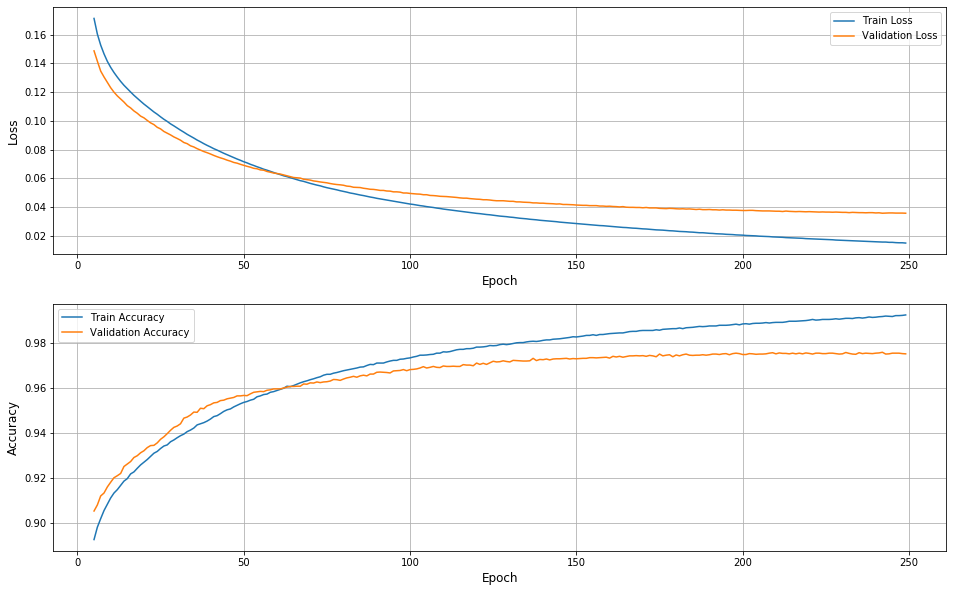

In [28]:
# Plot train/validation curves
fig, ax= plt.subplots(nrows=2, ncols=1,figsize=(16,10))

ep = list(range(epochs))
ax[0].plot(ep[5:], train_loss[5:], label='Train Loss')
ax[0].plot(ep[5:], valid_loss[5:], label='Validation Loss')
ax[0].set_xlabel('Epoch', fontsize=12)
ax[0].set_ylabel('Loss', fontsize=12)
ax[0].grid()
ax[0].legend()

ax[1].plot(ep[5:], train_acc[5:], label='Train Accuracy')
ax[1].plot(ep[5:], valid_acc[5:], label='Validation Accuracy')
ax[1].set_xlabel('Epoch', fontsize=12)
ax[1].set_ylabel('Accuracy', fontsize=12)
ax[1].grid()
ax[1].legend()
 
plt.show()

In [29]:
# Testing the network on test dataset
test_set_size = len(test_inputs)
print(f"Testing on {len(test_targets)} test samples")
loss, correct_cnt = (0.0, 0)

for i in range(test_set_size):
    # feed forward
    layer_0 = test_inputs[i]
    layer_1 = tanh(np.dot(layer_0, weights_0_1) + bias_0_1)
    layer_2 = np.exp(np.dot(layer_1, weights_1_2) + bias_1_2)\
              /np.sum(np.exp(np.dot(layer_1, weights_1_2) + bias_1_2))

    predict = np.argmax(layer_2)
    target = np.argmax(test_targets[i])

    #calculating loss
    loss += np.sum((test_targets[i] - layer_2)**2)
    correct_cnt += int(predict == target)

loss_function = round(loss / test_set_size, 4)
test_accuracy = round(correct_cnt / test_set_size, 4)
sys.stdout.write(f"\rLoss function value: {loss_function}"+
                 f"\tCorrectly classified {correct_cnt}"+
                 f" of {len(test_targets)} images" )
print(f"\nTest accuracy: {test_accuracy}")

Testing on 10000 test samples
Loss function value: 0.0354	Correctly classified 9770 of 10000 images
Test accuracy: 0.977


## Regularization: L1 and L2

In [31]:
# ^^^ Ok,now the trainig accuracy of > 99% looks quite good,
# however on validation/test datasets it drops about 1.5%,
# which is a lot... Looks like the model overfits
# Adding reularization may help to reduce overfitting
# let's chek it out

# Network settings and utility functions
# using tanh and softmax activation
tanh = lambda x: np.tanh(x)
tanh_deriv = lambda x: 1 - x**2
softmax = lambda x: np.exp(x)/np.sum(np.exp(x),\
                                     axis=1, keepdims=True)

# before each training epoch we'll randomly shuffle (intput, target)'s
def shuffle(*ls):
    l = list(zip(*ls))
    np.random.shuffle(l)
    return map(np.array, zip(*l))

np.random.seed(1)

# Topology of the network
INPUT_LAYER_SIZE = 784 # inputs
hidden_layer_size = 100 # one hidden layer with 100 neurons
OUTPUT_LAYER_SIZE = 10  # outputs

# Initial weights and biases initialized randomly using uniform distribution
weights_0_1 = 0.05 * (np.random.random((INPUT_LAYER_SIZE,\
                                        hidden_layer_size))-0.5)
bias_0_1 = 0.0 * (np.random.random(hidden_layer_size)-0.5)

weights_1_2 = 0.05 * (np.random.random((hidden_layer_size,\
                                        OUTPUT_LAYER_SIZE))-0.5)
bias_1_2 = 0.0 * (np.random.random(OUTPUT_LAYER_SIZE)-0.5)

# traning data
inputs = train_inputs
targets = train_targets

# training on < len(inputs) > samples
training_set_size = len(inputs)

# using validation
validation_set_size = len(validation_inputs)

# regularization parameters
l1 = 0.005
l2 = 2.25
# learning hyperparameters
alpha = 0.03 # learning rate
epochs = 2700 # number of epochs to train

# here we define batch size, to use batch of samples
# instead of single sample for input at each training step
batch_size  = 20

In [34]:
# Training the network
print(f"Training ANN on {training_set_size} samples in progress...")

train_loss = []
valid_loss = []
train_acc = []
valid_acc = []
for it in range(epochs):
    inputs,targets = shuffle(inputs, targets)
    loss, correct_cnt = (0.0, 0)
    
    for i in range(training_set_size//batch_size):
        batch_start,batch_end = (i*batch_size, (i+1)*batch_size)
        # TRANING
        # feed forward
        # using batch of samples instead of single sample
        layer_0 = inputs[batch_start:batch_end]
        layer_1 = tanh(np.dot(layer_0, weights_0_1) + bias_0_1)
        layer_2 = softmax(np.dot(layer_1, weights_1_2) + bias_1_2)
        
        # calculating loss and number of correcly predicted targets
        loss += np.sum((targets[batch_start:batch_end] - layer_2)**2)
        for k in range(batch_size):
            correct_cnt += int(np.argmax(layer_2[k:k+1]) == \
                               np.argmax(targets[(batch_start+k):(batch_start+k+1)]))
        
        # backpropagation (HERE weadd l1 and l2 regularization terms)
        layer_2_delta = (targets[batch_start:batch_end] - layer_2)\
                        /(batch_size * layer_2.shape[0])
        layer_1_delta = layer_2_delta.dot(weights_1_2.T)\
                        *tanh_deriv(layer_1)

        weights_1_2 = weights_1_2 + alpha*layer_1.T.dot(layer_2_delta)\
                                  - alpha*(l2/training_set_size)*weights_1_2\
                                  - alpha*(l1/training_set_size)*np.sign(weights_1_2)
        bias_1_2 += alpha * np.sum(layer_2_delta, axis=0)

        weights_0_1 = weights_0_1 + alpha*layer_0.T.dot(layer_1_delta)\
                                  - alpha*(l2/training_set_size)*weights_0_1\
                                  - alpha*(l1/training_set_size)*np.sign(weights_0_1)
        bias_0_1 += alpha * np.sum(layer_1_delta, axis = 0)
        
    #loss function and accuracy
    loss_function  = round(loss/training_set_size\
                          + l2*(np.sum(weights_0_1.dot(weights_0_1.T))\
                               +np.sum(weights_1_2.dot(weights_1_2.T)))\
                                 /(2*training_set_size)\
                          + l1*(np.abs(np.sum(weights_0_1))\
                               +np.abs(np.sum(weights_1_2)))\
                                 /training_set_size, 4)
    train_loss.append(loss_function)

    train_accuracy = round(correct_cnt/training_set_size, 4)
    train_acc.append(train_accuracy)
    
    # VALIDATION
    v_loss, v_correct_cnt = (0.0, 0)
    for i in range(validation_set_size):
        v_layer_0 = validation_inputs[i]
        v_layer_1 = tanh(np.dot(v_layer_0, weights_0_1) + bias_0_1)
        v_layer_2 = np.exp(np.dot(v_layer_1, weights_1_2) + bias_1_2)\
                    /np.sum(np.exp(np.dot(v_layer_1, weights_1_2) + bias_1_2))
        
        v_predict = np.argmax(v_layer_2)
        v_target = np.argmax(validation_targets[i])
     
        v_loss += np.sum((validation_targets[i] - v_layer_2)**2)
        v_correct_cnt += int(v_predict == v_target)

    v_loss_function = round(v_loss/validation_set_size\
                           + l2*(np.sum(weights_0_1.dot(weights_0_1.T))\
                                 +np.sum(weights_1_2.dot(weights_1_2.T)))\
                                   /(2*validation_set_size)\
                           + l1*(np.abs(np.sum(weights_0_1))\
                                 +np.abs(np.sum(weights_1_2)))\
                                   /validation_set_size, 4)
    valid_loss.append(v_loss_function)
    
    validation_accuracy = round(v_correct_cnt / validation_set_size, 4)
    valid_acc.append(validation_accuracy)

    # output\n",
    sys.stdout.write(f"\rEpoch: {it} Loss function value: {loss_function}"+
                     f"\tCorrectly classified {correct_cnt} of "+
                     f"{training_set_size} training images"+
                     f" ({round(train_accuracy*100,2)} %)"+
                     f"\tValidation: Correctly classified "+
                     f"{v_correct_cnt} of {validation_set_size}"+
                     f" validation images ({round(validation_accuracy*100,2)} %)")

print(f"\nTraining finished!\\nFinal traning accuracy: {train_accuracy}")
print(f"Final validation accuracy: {validation_accuracy}")

Training ANN on 50000 samples in progress...
Epoch: 2699 Loss function value: 0.0492	Correctly classified 49336 of 50000 training images (98.67 %)	Validation: Correctly classified 9791 of 10000 validation images (97.91 %)
Training finished!\nFinal traning accuracy: 0.9867
Final validation accuracy: 0.9791


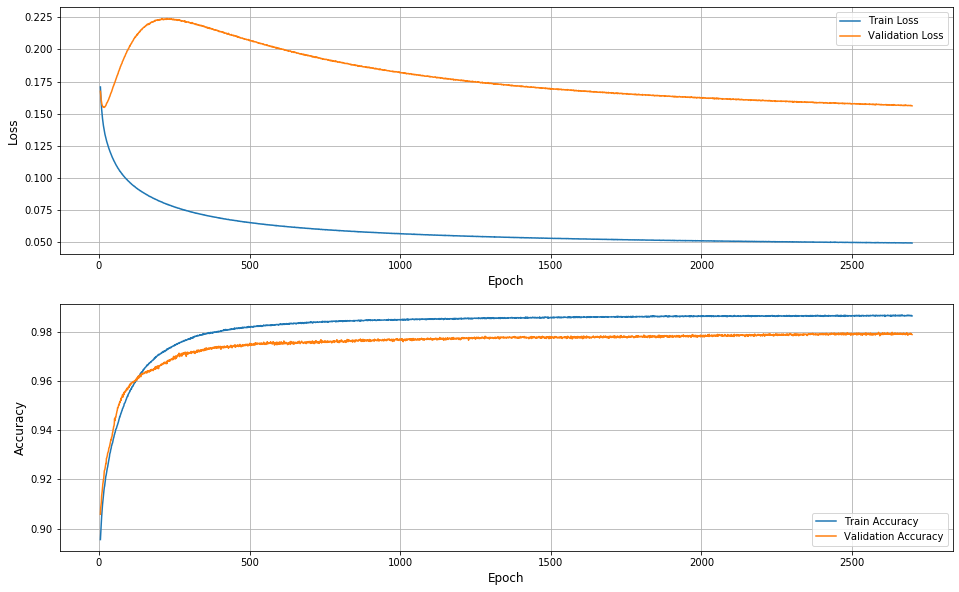

In [35]:
# Plot train/validation
fig, ax= plt.subplots(nrows=2, ncols=1,figsize=(16,10))

ep = list(range(epochs))
ax[0].plot(ep[5:], train_loss[5:], label='Train Loss')
ax[0].plot(ep[5:], valid_loss[5:], label='Validation Loss')
ax[0].set_xlabel('Epoch', fontsize=12)
ax[0].set_ylabel('Loss', fontsize=12)
ax[0].grid()
ax[0].legend()

ax[1].plot(ep[5:], train_acc[5:], label='Train Accuracy')
ax[1].plot(ep[5:], valid_acc[5:], label='Validation Accuracy')
ax[1].set_xlabel('Epoch', fontsize=12)
ax[1].set_ylabel('Accuracy', fontsize=12)
ax[1].grid()
ax[1].legend()

plt.show()

In [38]:
# Testing the network on test dataset
test_set_size = len(test_inputs)
print(f"Testing on {len(test_targets)} test samples")
loss, correct_cnt = (0.0, 0)
missclass = []
for i in range(test_set_size):
    # feed forward\n",
    layer_0 = test_inputs[i]
    layer_1 = tanh(np.dot(layer_0, weights_0_1) + bias_0_1)
    layer_2 = np.exp(np.dot(layer_1, weights_1_2) + bias_1_2)\
              /np.sum(np.exp(np.dot(layer_1, weights_1_2) + bias_1_2))
    
    predict = np.argmax(layer_2)
    target  = np.argmax(test_targets[i])
    
    #calculating loss
    loss += np.sum((test_targets[i] - layer_2)**2)
    correct_cnt += int(predict == target)
    if not predict == target:
        # store indecies of missclassified samples
        # along with ANN predictions
        missclass.append((i,predict))

loss_function = round(loss/test_set_size\
                      + l2*(np.sum(weights_0_1.dot(weights_0_1.T))\
                            +np.sum(weights_1_2.dot(weights_1_2.T)))\
                             /(2*test_set_size)\
                      + l1*(np.abs(np.sum(weights_0_1))\
                            +np.abs(np.sum(weights_1_2)))\
                             /test_set_size, 4)

test_accuracy = round(correct_cnt / test_set_size, 4)

sys.stdout.write(f"\rLoss function value: {loss_function}"+
                 f"\tCorrectly classified {correct_cnt}"+
                 f" of {len(test_targets)} images" )
print(f"\nTest accuracy: {test_accuracy}")

Testing on 10000 test samples
Loss function value: 0.1573	Correctly classified 9768 of 10000 images
Test accuracy: 0.9768


In [39]:
# Regularization helped to reduce overfitting,
# however I was not able to manualy tune hyperparameters
# to achieve the accuracy on test considerably higher than 0.975

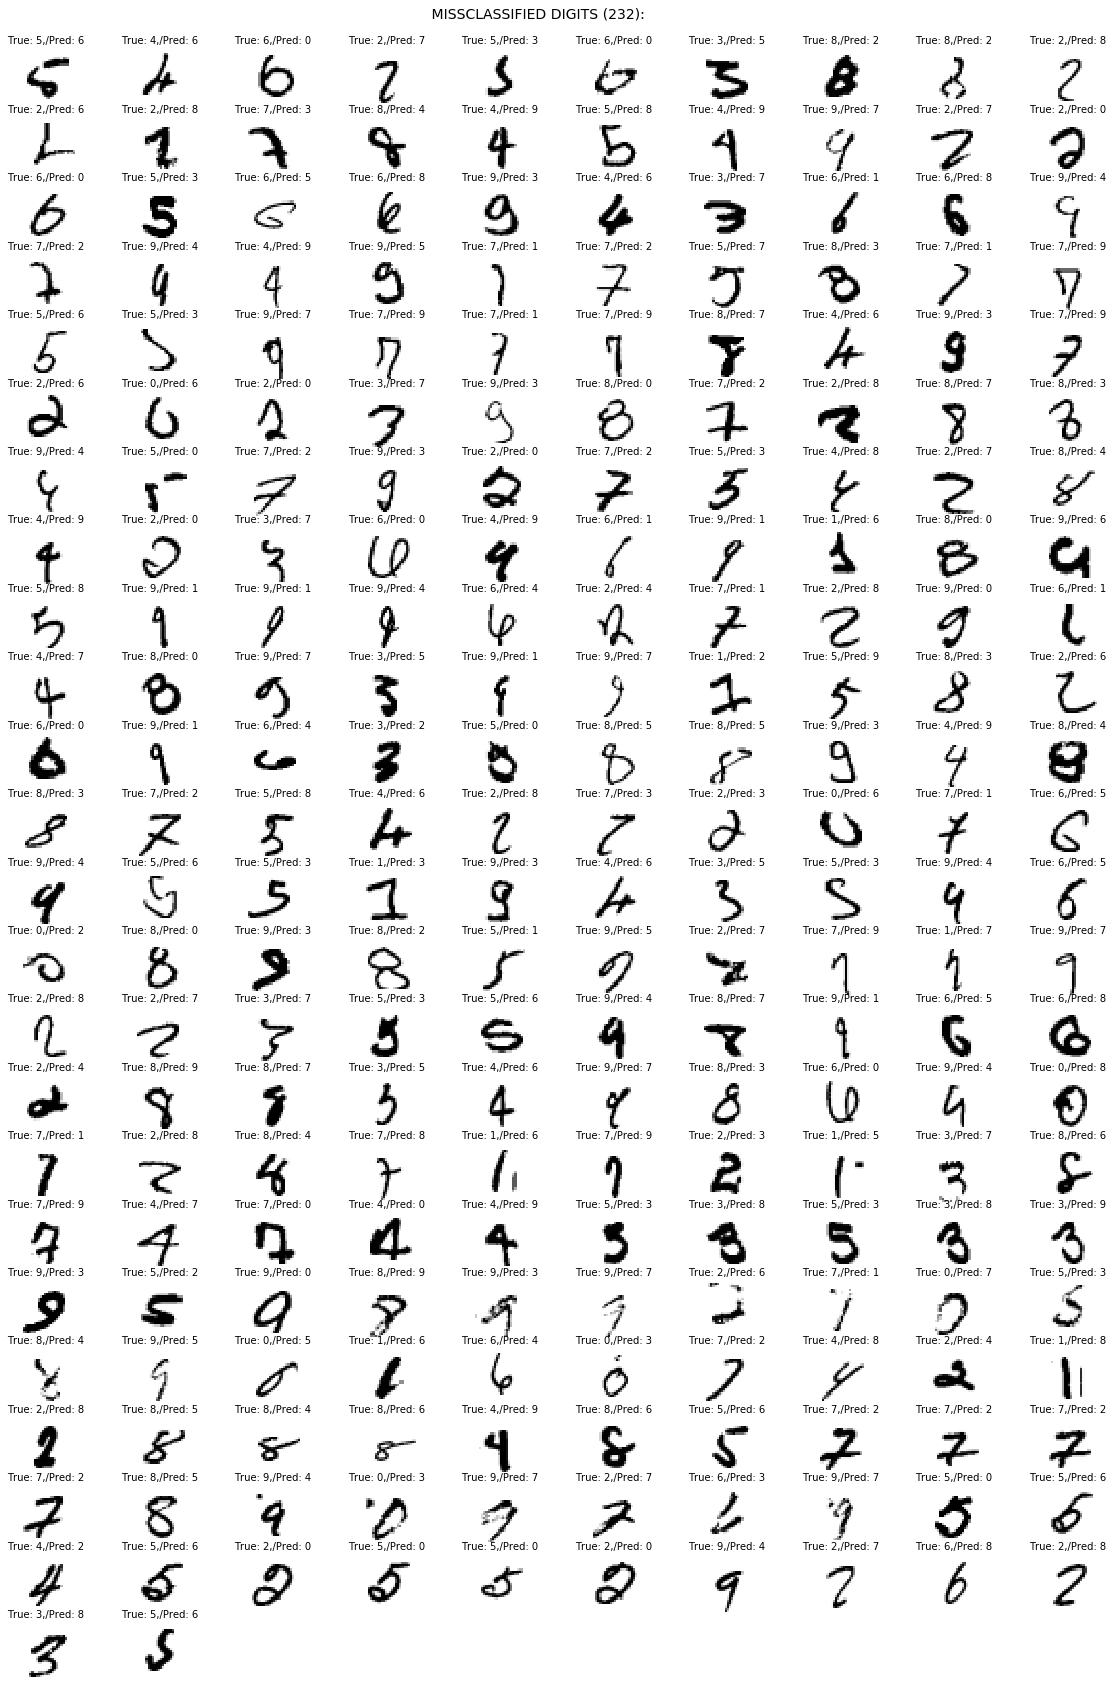

In [42]:
# Let's take a look at samples that are incorrectly classified by the ANN
N = len(missclass)
images, labels = x_test, y_test
fig, ax= plt.subplots(nrows=N//10+1, ncols=10, figsize=(20,30))
ax = ax.flatten()

empt_axs, i = 10*(N//10+1) - N, 1
while i <= empt_axs:
    ax[-i].set_visible(False)
    i += 1

for i in range(N):
    ax[i].imshow(images[missclass[i][0]], cmap=mpl.cm.binary, interpolation='nearest')
    ax[i].axis('off')
    ax[i].set_title(f"True: {labels[missclass[i][0]]},/Pred: {missclass[i][1]}",fontsize=10)
plt.suptitle(f" MISSCLASSIFIED DIGITS ({N}): ",fontsize=14, y=0.9)
plt.show()

In [41]:
# ^^^ Well... some of the misclassified digits looks pretty ugly and hard to recognize
# even for human. Nevertheless, there are still lots of digits that are clearly recognizable